In [1]:
import cv2
import os

# Folder containing the images
folder = '/home/roxane/Desktop/VID_annotated_2'

# Get a list of all the images in the folder
images = [f for f in os.listdir(folder) if f.endswith('.jpg')]
images.sort()

# Define the codec and create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('COMPLETEVIDCROP.mp4', fourcc, 30.0, (500, 185))

for image in images:
    # Load the image
    img = cv2.imread(os.path.join(folder, image))

    # Write the image to the video writer object
    out.write(img)

# Release the video writer object
out.release()


In [1]:
import cv2
import numpy as np
import Evaluation
import Preprocessing
import RansacProcess
import HoughProcess
import ExtractfromRosPackage
import SettingUp
import matplotlib.pyplot as plt



VID = 0
IMG = 1
EVAL = True

def the_old_main(name_images, nb_crop):

    """
    hyperparameters : 
        - nb_crops : by def = 4
        - mode : single img or video?
        - if VID : folder containing the images
        - if IMG : foler + name of the image
    """

    mode = IMG
    nb_row = nb_crop
    folder = '/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines' 
    #folder = '/home/roxane/Desktop/M3_2022/USB/Realsense_18-08-2022_10-46-58'
    #folder = '/home/roxane/Desktop/M3_2022/Caterra/crop-detection/Images_Preprocess'

    #initialisation of param : 
    hough_flag = 1
    list_rows = []
    list_rows_hough = []
    list_validity = []
    idx_since_hough = 0
    av_info = 0

    
    if (mode == VID):
        name_images = SettingUp.obtain_name_images(folder)

    images = SettingUp.obtain_images(name_images, folder, mode)
    height_sky, col_veg, av_info = Preprocessing.init(images[0], mode)

    for idx, image in enumerate(images) : 

        image = image[height_sky:,:,:]
        vegetation_mask = Preprocessing.get_vegetation_mask(image, height_sky, col_veg, mode, av_info)
        valid = 0
        
        while(valid==0):
            if(hough_flag==1):
                masks, vp, hough_image, pts1_hough, pts2_hough, nb_row = HoughProcess.find_approx(image, vegetation_mask, nb_row)
                hough_flag = 0
                idx_since_hough = 0
                rows_hough = [pts1_hough, pts2_hough]
                list_rows_hough.append(rows_hough)



            if(hough_flag==0):
                valid, masks, pts1, pts2, img_annotated = RansacProcess.find_rows(image, masks, vp, vegetation_mask)
                rows = [pts1, pts2]


                if ((idx_since_hough%5==0) and (idx_since_hough>0)):
                    valid = 0
                
                if (idx_since_hough==0 and valid == 1):
                    list_rows.append(rows)
                    list_validity.append(1)

                if (idx_since_hough == 0 and valid == 0): 
                    list_rows.append(rows)
                    list_validity.append(0)
                    valid = 1 # we did our best, go to next frame anyway 

                if (idx_since_hough>0 and valid == 1): 
                    list_rows.append(rows)
                    list_validity.append(1)

                if (idx_since_hough>0 and valid == 0): #do the hough process 
                    hough_flag = 1
        
        idx_since_hough = idx_since_hough + 1 

        filename = '/home/roxane/Desktop/img_annotated_clean/img_' + str(idx).zfill(3) + '.jpg'
        cv2.imwrite(filename,  cv2.cvtColor(img_annotated, cv2.COLOR_RGB2BGR))
        if(mode==VID):
            if cv2.waitKey(1) == ord('q'):
                break
        
        if(EVAL == True):
            #if(mode == IMG):
            crop_only_ransac = Evaluation.SaveData(img_annotated, list_rows[0], 0) #put cond for hough and ransac
            crop_only_hough = Evaluation.SaveData(hough_image, list_rows_hough[0], 1)

            GTImage, ComparaisonImage, BlankImage, cv, dv, v0, array_GT = Evaluation.LoadGroundTruth(name_images, img_annotated, height_sky)
            score_RANSAC, precision_RANSAC = Evaluation.evaluate_results(cv, dv, v0, height_sky, array_GT, type= 0, nb_crop_row=nb_row)
            score_Hough, precision_Hough = Evaluation.evaluate_results(cv, dv, v0, height_sky, array_GT, type= 1, nb_crop_row=nb_row)
            plt.imshow(img_annotated)

        if(mode==IMG):
            filename = '/home/roxane/Desktop/Results/' + 'BlankImage' + name_images
            cv2.imwrite(filename, BlankImage)
            filename = '/home/roxane/Desktop/Results/' + 'GTImage' + name_images
            cv2.imwrite(filename, GTImage)
            filename = '/home/roxane/Desktop/Results/' + 'ComparaisonImage' + name_images
            cv2.imwrite(filename, cv2.cvtColor(ComparaisonImage, cv2.COLOR_RGB2BGR))
            filename = '/home/roxane/Desktop/Results/' + 'HoughCrops' + name_images
            cv2.imwrite(filename, cv2.cvtColor(hough_image, cv2.COLOR_RGB2BGR))
            filename = '/home/roxane/Desktop/Results/' + 'RANSAC crops' + name_images
            cv2.imwrite(filename, cv2.cvtColor(img_annotated, cv2.COLOR_RGB2BGR))
            filename = '/home/roxane/Desktop/Results/' + 'VEGETATION Image' + name_images
            cv2.imwrite(filename, vegetation_mask)

    return score_RANSAC, score_Hough, precision_RANSAC, precision_Hough, vegetation_mask, hough_image, ComparaisonImage, img_annotated




In [2]:
import os

lst = os.listdir('/home/roxane/Desktop/M3_2022/Caterra/dataset_straigt_lines')
lst.sort()
name_images = [img for img in lst 
                if img.endswith(".jpg") or
                    img.endswith(".jpeg") or
                    img.endswith(".JPG") or
                    img.endswith("png")]

nb_crop -=1
nb_crop -=1
idx :  0 out of  47 score RANSAC :  0.9498209301307996 score Hough :  0.9528304956362137
idx :  1 out of  47 score RANSAC :  0.8597654905652582 score Hough :  0.8386104078147656
idx :  2 out of  47 score RANSAC :  0.8419533093882811 score Hough :  0.7868496968757077
idx :  3 out of  47 score RANSAC :  0.9796612531217262 score Hough :  0.9708703677813648
idx :  4 out of  47 score RANSAC :  0.9044441085874363 score Hough :  0.8916008645425391
idx :  5 out of  47 score RANSAC :  0.8413504898428747 score Hough :  0.8184807208860303
idx :  6 out of  47 score RANSAC :  0.9910582644619077 score Hough :  0.9882325338546483
bushy
idx :  7 out of  47 score RANSAC :  0.7816572782586176 score Hough :  0.7748901296996039
bushy
idx :  8 out of  47 score RANSAC :  0.7725922997289038 score Hough :  0.7316817722903527
idx :  9 out of  47 score RANSAC :  0.6805111571608949 score Hough :  0.7269371472817957
idx :  10 out of  47 score RANSAC :  0.8691497465138344 score Hough :  0.7

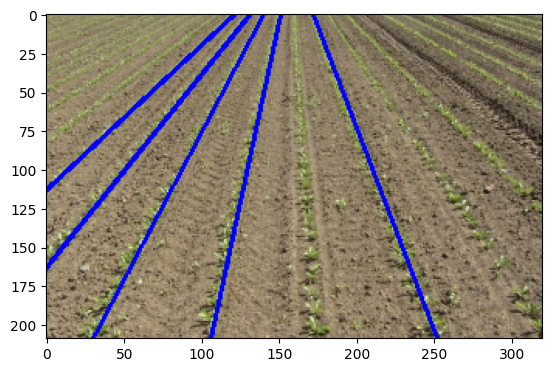

In [3]:
list_score_ran = []
list_score_hough= []

for idx,a in enumerate(name_images):
     nb_crop = 5
     score_RANSAC, score_Hough, precision_RANSAC, precision_Hough, vegetation_mask, hough_image, ComparaisonImage, img_annotated = the_old_main(a, nb_crop);
     list_score_ran.append(score_RANSAC)
     list_score_hough.append(score_Hough)
     print('idx : ', idx, 'out of ', len(name_images), 'score RANSAC : ', score_RANSAC, 'score Hough : ', score_Hough)


In [4]:
arr_score_ransac = np.asarray(list_score_ran)
mean_ransac = np.mean(arr_score_ransac)
median_ransac = np.median(arr_score_ransac)

arr_score_hough = np.asarray(list_score_hough)
mean_hough = np.mean(arr_score_hough)
median_hough = np.median(arr_score_hough)

print(mean_ransac,median_ransac,mean_hough, median_hough)

0.8025802253489853 0.8640571023424878 0.7916082316299727 0.843910147142127


In [9]:
arr_score_ransac = np.asarray(list_score_ran)
mean_ransac = np.mean(arr_score_ransac)
median_ransac = np.median(arr_score_ransac)

arr_score_hough = np.asarray(list_score_hough)
mean_hough = np.mean(arr_score_hough)
median_hough = np.median(arr_score_hough)

print(mean_ransac,median_ransac,mean_hough, median_hough)

0.8025802253489853 0.8640571023424878 0.7916082316299727 0.843910147142127


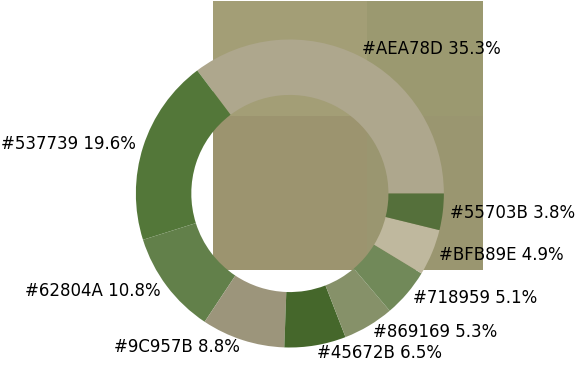

In [15]:
score_RANSAC, score_Hough, precision_RANSAC, precision_Hough, vegetation_mask, hough_image, ComparaisonImage, img_annotated = the_old_main('crop_row_047.JPG',2)

In [16]:
score_RANSAC

0.7377787533502479

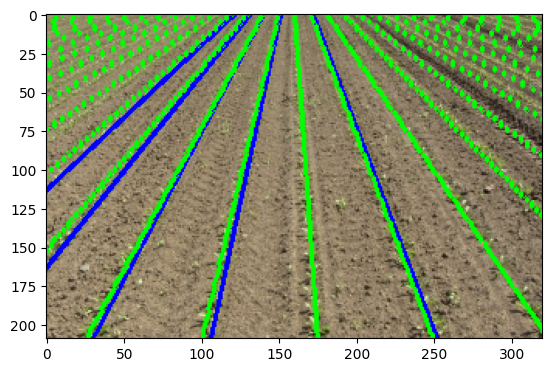

In [5]:
plt.imshow(ComparaisonImage)

In [8]:
list_score_ran

[0.9498209301307996,
 0.8597654905652582,
 0.8419533093882811,
 0.9796612531217262,
 0.9044441085874363,
 0.8413504898428747,
 0.9910582644619077,
 0.7816572782586176,
 0.7725922997289038,
 0.6805111571608949,
 0.8691497465138344,
 0.9717382376827665,
 0.9882356720504523,
 0.8488361444782264,
 0.8227142397240613,
 0.9197271148766114,
 0.9292051754114371,
 0.8640571023424878,
 0.9768680956535986,
 0.9743335316958567,
 0.8978021935753938,
 0.9175443598628529,
 0.7717645342088654,
 0.9871042673436237,
 0.9457696762274348,
 0.8940597773181872,
 0.9350370641600192,
 0.7151773247143574,
 0.8996532969159707,
 0.7294084997304935,
 0.8407749402566399,
 0.7068532912845145,
 0.47991533852513324,
 0.38725412707984014,
 0.3418320924631727,
 0.8776453113974448,
 0.46196965512715177,
 0.3165007230925116,
 0.6384437008640849,
 0.935048620041828,
 0.9591721199432864,
 0.7962266692905915,
 0.7444023318570556,
 0.9640216408220327,
 0.9405087049685398,
 0.09423076731843594,
 0.7754699213368241]